In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset
data = pd.read_csv('/content/gdrive/MyDrive/Oxford - project/End to end/Project/synthetic_data_2019_2024_new.csv')

## Data Cleansing

In [ ]:
# Remove duplicates
print(f"Number of duplicate rows: {data.duplicated().sum()}")
data = data.drop_duplicates()

Number of duplicate rows: 0


In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Store ID            0
Country             0
Product ID          0
Product Category    0
Units Sold          0
Date of Sale        0
GDP Growth Rate     0
Inflation Rate      0
Price Sold          0
dtype: int64


In [ ]:
# Fill missing values for numerical columns
data['GDP Growth Rate'].fillna(data['GDP Growth Rate'].mean(), inplace=True)
data['Inflation Rate'].fillna(data['Inflation Rate'].median(), inplace=True)

# Fill missing values for categorical columns
data['Product Category'].fillna('Unknown', inplace=True)

# Convert 'Date of Sale' to datetime format
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Standardize categorical values
data['Country'] = data['Country'].str.strip().str.title()
data['Product Category'] = data['Product Category'].str.strip().str.title()

# Detect and handle outliers for numerical columns using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

data = remove_outliers(data, 'Units Sold')
data = remove_outliers(data, 'Price Sold')

# Display cleaned data
print(data.head())

   Store ID Country  Product ID Product Category  Units Sold Date of Sale  \
0      7120   Italy       49634           Womens           6   2022-01-31   
1      8459   Spain       80283             Mens           7   2022-12-30   
2      6871   Italy       85670             Mens          14   2021-05-10   
4      1034      Uk       11583           Womens           9   2022-02-04   
5      5498   Italy       11553           Womens           8   2021-12-31   

   GDP Growth Rate  Inflation Rate  Price Sold  
0            -1.63           14.56      386.17  
1            -1.61            9.08      240.99  
2            11.62          -20.54     -531.77  
4             2.38            2.52       69.15  
5             2.76            7.10      191.32  


## Exploratory Data Analysis (EDA)

In [ ]:
#DATE RANGE

print("Date range:", data['Date of Sale'].min(), "to", data['Date of Sale'].max())

Date range: 2019-01-01 00:00:00 to 2024-04-30 00:00:00


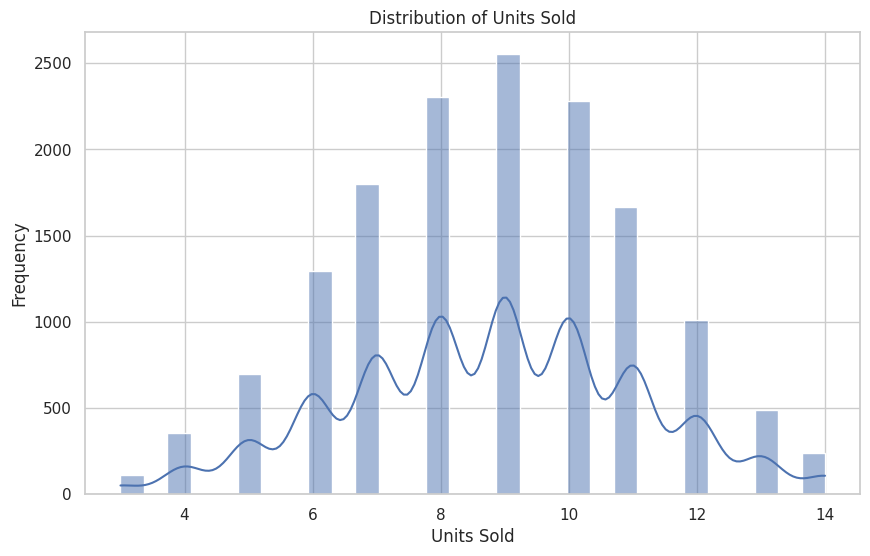

In [ ]:
# Set the plot style
sns.set(style="whitegrid")

# 1. Distribution of Units Sold
plt.figure(figsize=(10, 6))
sns.histplot(data['Units Sold'], bins=30, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()


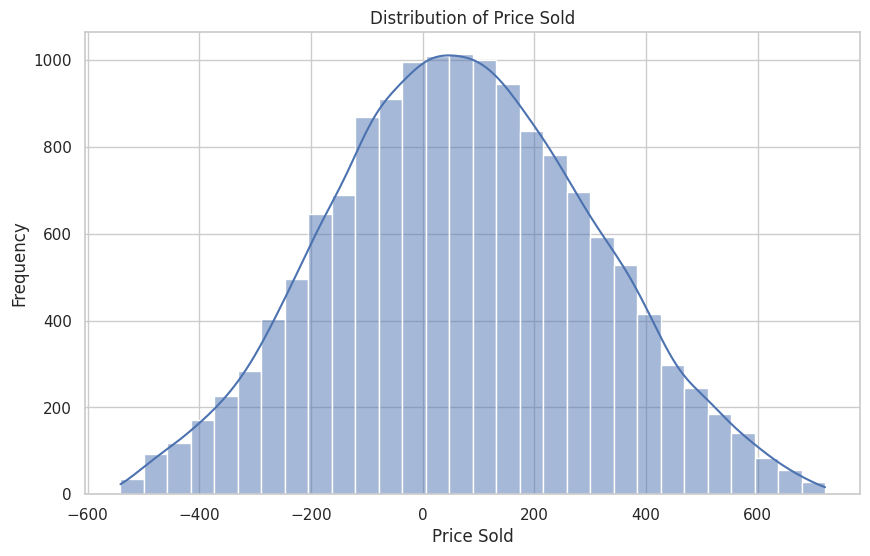

In [ ]:
# 2. Distribution of Price Sold
plt.figure(figsize=(10, 6))
sns.histplot(data['Price Sold'], bins=30, kde=True)
plt.title('Distribution of Price Sold')
plt.xlabel('Price Sold')
plt.ylabel('Frequency')
plt.show()

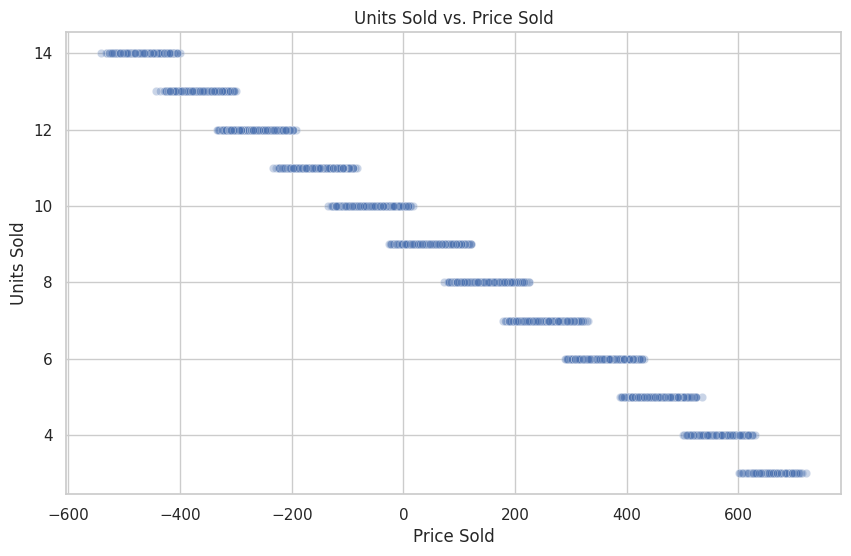

In [ ]:
# 3. Relationship between Units Sold and Price Sold
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Price Sold', y='Units Sold', data=data, alpha=0.3)
plt.title('Units Sold vs. Price Sold')
plt.xlabel('Price Sold')
plt.ylabel('Units Sold')
plt.show()

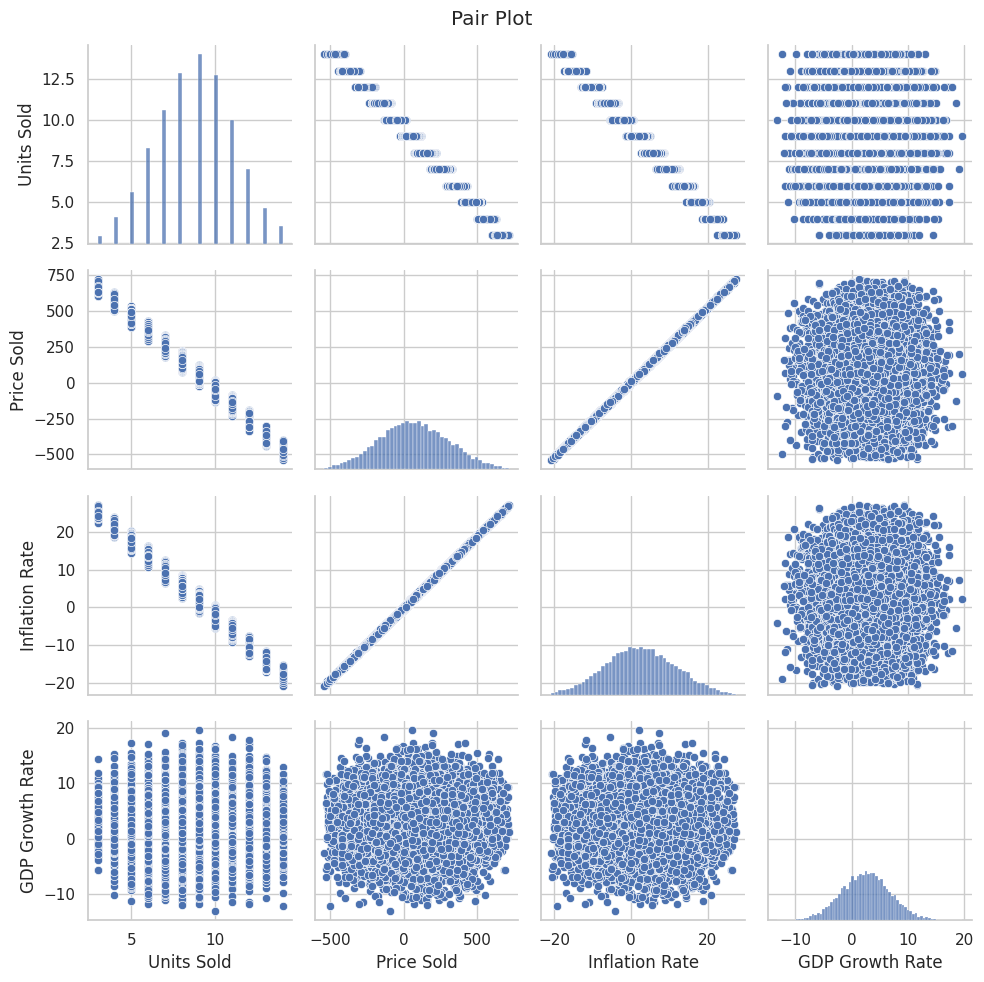

In [ ]:
# Pair plot
sns.pairplot(data, vars=['Units Sold', 'Price Sold', 'Inflation Rate', 'GDP Growth Rate'])
plt.suptitle('Pair Plot')
plt.tight_layout()
plt.show()

## Feature Engineering

In [ ]:
# Convert 'Date of Sale' to datetime
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

In [ ]:
# Prophet model - sort the data
data_p = data.sort_values(by='Date of Sale')

# Prepare the data for Prophet
prophet_data = data_p[['Date of Sale', 'Units Sold']]
prophet_data = prophet_data.rename(columns={'Date of Sale': 'ds', 'Units Sold': 'y'})

In [ ]:
# Extract date features
data['Year'] = data['Date of Sale'].dt.year.astype(int)
data['Month'] = data['Date of Sale'].dt.month.astype(int)
data['Day'] = data['Date of Sale'].dt.day.astype(int)
data['DayOfWeek'] = data['Date of Sale'].dt.dayofweek.astype(int)
data['WeekOfYear'] = data['Date of Sale'].dt.isocalendar().week.astype(int)

In [ ]:
# Define seasons based on month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

data['Season'] = data['Month'].apply(get_season)

In [ ]:
# Define holidays using the holidays library
uk_holidays = holidays.UnitedKingdom()

# Add is_holiday column based on 'Date of Sale'
data['is_holiday'] = data['Date of Sale'].apply(lambda x: 1 if x in uk_holidays else 0)

# Add is_weekend column
data['is_weekend'] = data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

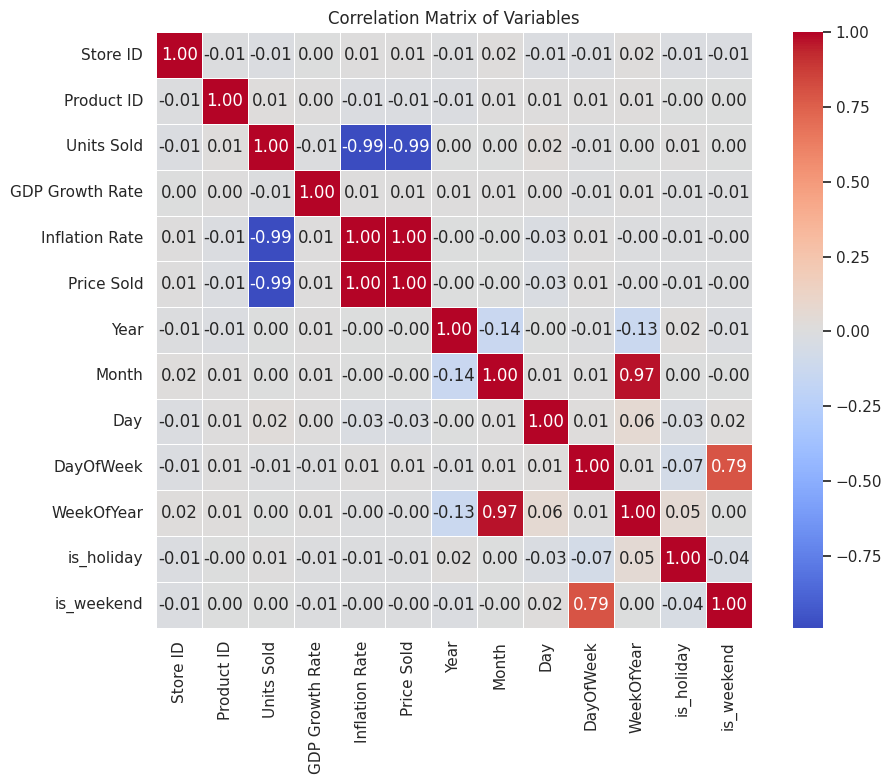

In [ ]:
# Correlation matrix
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)
plt.title('Correlation Matrix of Variables')
plt.tight_layout()
plt.show()


In [ ]:
# Create lag features for the past 12 months
data = data.sort_values(by='Date of Sale')
for lag in range(1, 13):
    data[f'Units_Sold_Lag_{lag}'] = data['Units Sold'].shift(lag)

In [ ]:
# Create rolling average and standard deviation features
data['Rolling_Avg_3_Months'] = data['Units Sold'].rolling(window=3).mean()
data['Rolling_Std_3_Months'] = data['Units Sold'].rolling(window=3).std()

In [ ]:
# Drop rows with NaN values created by lagging and rolling window
data = data.dropna()

# Save the unique values for categorical features before one-hot encoding
unique_countries = data['Country'].unique()
unique_product_categories = data['Product Category'].unique()

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Country', 'Product Category', 'Season'])

# Define numerical and categorical columns
numerical_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold',
                      'Units_Sold_Lag_1', 'Units_Sold_Lag_2', 'Units_Sold_Lag_3', 'Units_Sold_Lag_4', 'Units_Sold_Lag_5', 'Units_Sold_Lag_6',
                      'Units_Sold_Lag_7', 'Units_Sold_Lag_8', 'Units_Sold_Lag_9', 'Units_Sold_Lag_10', 'Units_Sold_Lag_11', 'Units_Sold_Lag_12',
                      'Rolling_Avg_3_Months', 'Rolling_Std_3_Months']
categorical_features = [col for col in data.columns if col not in numerical_features + ['Units Sold', 'Date of Sale']]

# Drop columns that won't be used directly for modeling
#data = data.drop(columns=['Date of Sale'])

# Display the first few rows of the engineered dataset
print(data.head())


      Store ID  Product ID  Units Sold Date of Sale  GDP Growth Rate  \
280       2067       95210          11   2019-01-02            -0.53   
2604      6281       25532          12   2019-01-02             1.24   
2444      8085       67325          10   2019-01-02             4.48   
356       3161       72134          12   2019-01-02             0.41   
2903      8204       56926          12   2019-01-02             4.12   

      Inflation Rate  Price Sold  Year  Month  Day  ...  Country_Germany  \
280            -4.88     -122.05  2019      1    2  ...            False   
2604           -8.45     -221.54  2019      1    2  ...            False   
2444           -2.54      -63.20  2019      1    2  ...            False   
356            -9.25     -235.67  2019      1    2  ...            False   
2903           -8.79     -223.58  2019      1    2  ...            False   

      Country_Italy  Country_Spain  Country_Uk  Product Category_Mens  \
280           False          False   

In [ ]:
# Normalize/Standardize numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [ ]:
# Define X and y for the entire dataset
X = data.drop(columns=['Units Sold', 'Date of Sale'])
y = data['Units Sold']

In [ ]:
# Set a split date
split_date = '2024-01-01'
train_data = data[data['Date of Sale'] < split_date]
test_data = data[data['Date of Sale'] >= split_date]

In [ ]:
# Split the data into train and test sets
X_train = train_data.drop(columns=['Units Sold', 'Date of Sale'])
y_train = train_data['Units Sold']
X_test = test_data.drop(columns=['Units Sold', 'Date of Sale'])
y_test = test_data['Units Sold']

## Modelling

In [ ]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

mse_lr, mae_lr, r2_lr = np.round(evaluate_model(y_test, y_pred_lr),2)
mse_rf, mae_rf, r2_rf = np.round(evaluate_model(y_test, y_pred_rf),2)

In [ ]:
# Compare Models
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [mse_lr, mse_rf],
    'MAE': [mae_lr, mae_rf],
    'R2 Score': [r2_lr, r2_rf]
})

print(results)


               Model   MSE   MAE  R2 Score
0  Linear Regression  0.00  0.00      1.00
1      Random Forest  0.05  0.11      0.99


In [ ]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate Linear Regression model with cross-validation
lr_cv_scores = cross_val_score(lr_model, X, y, cv=tscv, scoring='r2')
print(f"Linear Regression Cross-Validation R2 Scores: {lr_cv_scores}")
print(f"Mean R2 Score: {np.mean(lr_cv_scores)}")

# Evaluate Random Forest model with cross-validation
rf_cv_scores = np.round(cross_val_score(rf_model, X, y, cv=tscv, scoring='r2'),2)
print(f"Random Forest Cross-Validation R2 Scores: {rf_cv_scores}")
print(f"Mean R2 Score: {np.round(np.mean(rf_cv_scores),2)}")


Linear Regression Cross-Validation R2 Scores: [1. 1. 1. 1. 1.]
Mean R2 Score: 1.0
Random Forest Cross-Validation R2 Scores: [0.99 0.99 0.99 0.99 0.99]
Mean R2 Score: 0.99


## Reducing overfitting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import holidays
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Linear Regression with Regularization
ridge_model = Ridge()
param_grid = {'alpha': [0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge_model, param_grid, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
best_ridge = ridge_cv.best_estimator_

In [ ]:
# Random Forest Regressor with Hyperparameter Tuning
rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_cv = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='r2')
rf_cv.fit(X_train, y_train)
best_rf = rf_cv.best_estimator_


In [ ]:
# Predictions
y_pred_ridge = best_ridge.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

In [ ]:
# Evaluation
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

mse_ridge, mae_ridge, r2_ridge = evaluate_model(y_test, y_pred_ridge)
mse_rf, mae_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

results = pd.DataFrame({
    'Model': ['Ridge Regression', 'Random Forest'],
    'MSE': [mse_ridge, mse_rf],
    'MAE': [mae_ridge, mae_rf],
    'R2 Score': [r2_ridge, r2_rf]
})

print(results)

              Model       MSE       MAE  R2 Score
0  Ridge Regression  0.000545  0.019908  0.999899
1     Random Forest  0.052582  0.105695  0.990218


In [ ]:
# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate models with cross-validation
ridge_cv_scores = cross_val_score(best_ridge, X, y, cv=tscv, scoring='r2')
rf_cv_scores = cross_val_score(best_rf, X, y, cv=tscv, scoring='r2')

print(f"Ridge Regression Cross-Validation R2 Scores: {ridge_cv_scores}")
print(f"Mean R2 Score: {np.mean(ridge_cv_scores)}")

print(f"Random Forest Cross-Validation R2 Scores: {rf_cv_scores}")
print(f"Mean R2 Score: {np.mean(rf_cv_scores)}")

Ridge Regression Cross-Validation R2 Scores: [0.99817877 0.99933951 0.99967671 0.9998073  0.99987004]
Mean R2 Score: 0.9993744665653723
Random Forest Cross-Validation R2 Scores: [0.9874082  0.98879917 0.989228   0.98920574 0.98932953]
Mean R2 Score: 0.9887941259893143


In [ ]:
# Import necessary libraries
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Split the data into train and test sets
train_data = prophet_data[prophet_data['ds'] < '2024-01-01']
test_data = prophet_data[prophet_data['ds'] >= '2024-01-01']

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Make future dataframe
# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_data)

# Calculate the number of days in the test set
num_days_test = (test_data['ds'].max() - test_data['ds'].min()).days + 1

# Make future dataframe that includes the entire test set period
future = model.make_future_dataframe(periods=num_days_test)
forecast = model.predict(future)

# Merge the test data with the forecast dataframe
merged_data = pd.merge(test_data, forecast, on='ds')

# Align true and predicted values
y_true = merged_data['y'].values
y_pred = merged_data['yhat'].values


# Ensure the lengths are the same
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr2cwjqi5/3o6z6231.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr2cwjqi5/g7s6h7qz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26599', 'data', 'file=/tmp/tmpr2cwjqi5/3o6z6231.json', 'init=/tmp/tmpr2cwjqi5/g7s6h7qz.json', 'output', 'file=/tmp/tmpr2cwjqi5/prophet_modelr6tjg6tf/prophet_model-20240521143354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr2

Length of y_true: 947
Length of y_pred: 947


In [ ]:
mse = np.round(mean_squared_error(y_true, y_pred),2)
mae = np.round(mean_absolute_error(y_true, y_pred),2)
r2 = np.round(r2_score(y_true, y_pred),2)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")



Mean Squared Error: 5.38
Mean Absolute Error: 1.88
R2 Score: -0.0


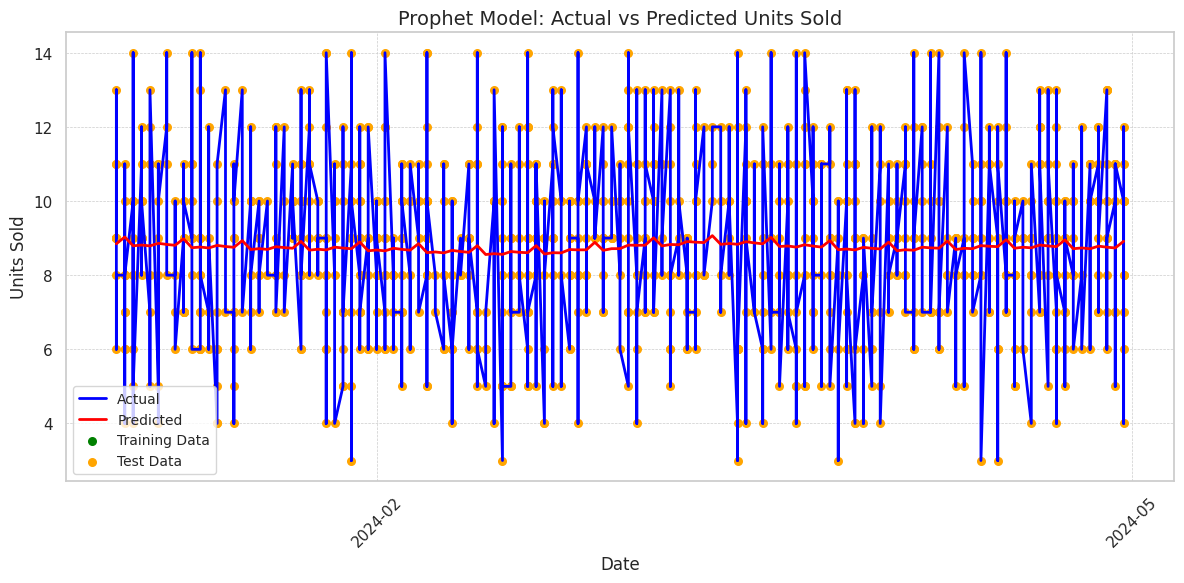

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Plot true vs predicted values
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax.plot(merged_data['ds'], y_true, label='Actual', color='blue', linewidth=2)

# Plot the predicted values
ax.plot(merged_data['ds'], y_pred, label='Predicted', color='red', linewidth=2)

# Plot the training data points
train_data_points = merged_data[merged_data['ds'] < '2024-01-01']
ax.scatter(train_data_points['ds'], train_data_points['y'], label='Training Data', color='green', marker='o', s=30)

# Add training data date range to the legend only if valid dates are available
train_start_date = train_data_points['ds'].min()
train_end_date = train_data_points['ds'].max()

if not pd.isnull(train_start_date) and not pd.isnull(train_end_date):
    train_start_date = train_start_date.strftime('%Y-%m-%d')
    train_end_date = train_end_date.strftime('%Y-%m-%d')
    ax.plot([], [], ' ', label=f'Training Data: {train_start_date} to {train_end_date}')

# Plot the test data points
test_data_points = merged_data[merged_data['ds'] >= '2024-01-01']
ax.scatter(test_data_points['ds'], test_data_points['y'], label='Test Data', color='orange', marker='o', s=30)

# Set the x-axis label and format
ax.set_xlabel('Date', fontsize=12)
date_formatter = DateFormatter('%Y-%m')
ax.xaxis.set_major_formatter(date_formatter)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Display labels every 3 months
plt.xticks(rotation=45)

# Set the y-axis label and format
ax.set_ylabel('Units Sold', fontsize=12)
ax.yaxis.set_major_formatter('{x:,.0f}')

# Set the title
ax.set_title('Prophet Model: Actual vs Predicted Units Sold', fontsize=14)

# Add a legend
ax.legend(fontsize=10)

# Add grid lines
ax.grid(True, linestyle='--', linewidth=0.5)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()